Cleaning Olympic Swimming Dataset

In [66]:
import numpy as np
import pandas as pd
import math
import json
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

In [67]:
data = pd.read_csv('data/olympic_swimming.csv')
df = pd.DataFrame(data)

In [68]:
df['Stroke'] = df['Stroke'].replace('Individual medley','Medley')
df['Distance'] = df['Distance'].replace({'4x100':'4x100m','4x200':'4x200m'})

In [69]:
df = df[(df['Results'] != 'Did not start') & (df['Results'] != 'Did not finish') & (df['Results'] != 'Disqualified')].dropna().reset_index() #Clearing out rows without times
df

,index,Location,Year,Distance,Stroke,Relay,Gender,Team,Athlete,Results,Rank
0,0,Tokyo,2020,4x100m,Freestyle,1,Men,USA,"Caeleb Dressel,Blake Pieroni,Bowe Becker,Zach ...",03.08.97,1
1,1,Tokyo,2020,4x100m,Freestyle,1,Men,ITA,"Alessandro Miressi,Thomas Ceccon,Lorenzo Zazze...",03.10.11,2
2,2,Tokyo,2020,4x100m,Freestyle,1,Men,AUS,"Matthew Temple,Zac Incerti,Alexander Graham,Ky...",03.10.22,3
3,3,Tokyo,2020,4x100m,Freestyle,1,Men,CAN,"Brent Hayden,Joshua Liendo,Yuri Kisil,Markus T...",03.10.82,4
4,4,Tokyo,2020,4x100m,Freestyle,1,Men,HUN,"Kristóf Milák,Szebasztián Szabó,Richárd Bohus,...",03.11.06,4
...,...,...,...,...,...,...,...,...,...,...,...
4264,4403,Stockholm,1912,4x100m,Freestyle,1,Women,AUT,"Margarete Adler, Bertha Zahourek, Josephine St...",06.17.00,3
4265,4405,Stockholm,1912,4x200m,Freestyle,1,Men,ANZ,"Malcolm Champion, Cecil Healy, Harold H. Hardw...",10.11.20,1
4266,4406,Stockholm,1912,4x200m,Freestyle,1,Men,USA,"Duke Paoa Kahanamoku, Harry J. Hebner, Perry M...",10.20.20,2
4267,4407,Stockholm,1912,4x200m,Freestyle,1,Men,GBR,"Thomas Sidney Battersby, Henry Taylor, John Ga...",10.28.60,3


In [70]:
temp = df['Results'].map(lambda x : x.split('.')) #Converting to just seconds
seconds = []


In [71]:
for entity in temp:
    if len(entity) == 1:
        seconds.append(float(entity[0]))
    elif len(entity) == 2:
        if (len(entity[1]) > 2): seconds.append(float(entity[0]) + float(entity[1])/1000)
        else: seconds.append(float(entity[0]) + float(entity[1])/100)
    elif len(entity) == 3:
        seconds.append(float(entity[0])*60 + float(entity[1]) + float(entity[2])/100)
df['Results'] = seconds

In [72]:
df_loc_year_merged = df.copy()
df_loc_year_merged['Location'] = df_loc_year_merged['Location'] + ' ' + df_loc_year_merged['Year'].astype('str')
df_loc_year_merged

,index,Location,Year,Distance,Stroke,Relay,Gender,Team,Athlete,Results,Rank
0,0,Tokyo 2020,2020,4x100m,Freestyle,1,Men,USA,"Caeleb Dressel,Blake Pieroni,Bowe Becker,Zach ...",188.97,1
1,1,Tokyo 2020,2020,4x100m,Freestyle,1,Men,ITA,"Alessandro Miressi,Thomas Ceccon,Lorenzo Zazze...",190.11,2
2,2,Tokyo 2020,2020,4x100m,Freestyle,1,Men,AUS,"Matthew Temple,Zac Incerti,Alexander Graham,Ky...",190.22,3
3,3,Tokyo 2020,2020,4x100m,Freestyle,1,Men,CAN,"Brent Hayden,Joshua Liendo,Yuri Kisil,Markus T...",190.82,4
4,4,Tokyo 2020,2020,4x100m,Freestyle,1,Men,HUN,"Kristóf Milák,Szebasztián Szabó,Richárd Bohus,...",191.06,4
...,...,...,...,...,...,...,...,...,...,...,...
4264,4403,Stockholm 1912,1912,4x100m,Freestyle,1,Women,AUT,"Margarete Adler, Bertha Zahourek, Josephine St...",377.00,3
4265,4405,Stockholm 1912,1912,4x200m,Freestyle,1,Men,ANZ,"Malcolm Champion, Cecil Healy, Harold H. Hardw...",611.20,1
4266,4406,Stockholm 1912,1912,4x200m,Freestyle,1,Men,USA,"Duke Paoa Kahanamoku, Harry J. Hebner, Perry M...",620.20,2
4267,4407,Stockholm 1912,1912,4x200m,Freestyle,1,Men,GBR,"Thomas Sidney Battersby, Henry Taylor, John Ga...",628.60,3


In [73]:
#Combining into one event name, used for pca
df_one_event_merged = df_loc_year_merged.copy()
df_one_event_merged['Relay'] = df_one_event_merged['Relay'].replace({0:'',1:'Relay'})
df_one_event_merged['Distance'] = df_one_event_merged['Gender'] + ' ' + df_one_event_merged['Distance'] + ' ' + df_one_event_merged['Stroke'] + ' ' + df_one_event_merged['Relay']
df_one_event_merged = df_one_event_merged.drop(['Stroke','Relay','Gender'],axis='columns')
df_one_event_merged['Distance'] = df_one_event_merged['Distance'].map(lambda x : x.strip())
df_one_event_merged

,index,Location,Year,Distance,Team,Athlete,Results,Rank
0,0,Tokyo 2020,2020,Men 4x100m Freestyle Relay,USA,"Caeleb Dressel,Blake Pieroni,Bowe Becker,Zach ...",188.97,1
1,1,Tokyo 2020,2020,Men 4x100m Freestyle Relay,ITA,"Alessandro Miressi,Thomas Ceccon,Lorenzo Zazze...",190.11,2
2,2,Tokyo 2020,2020,Men 4x100m Freestyle Relay,AUS,"Matthew Temple,Zac Incerti,Alexander Graham,Ky...",190.22,3
3,3,Tokyo 2020,2020,Men 4x100m Freestyle Relay,CAN,"Brent Hayden,Joshua Liendo,Yuri Kisil,Markus T...",190.82,4
4,4,Tokyo 2020,2020,Men 4x100m Freestyle Relay,HUN,"Kristóf Milák,Szebasztián Szabó,Richárd Bohus,...",191.06,4
...,...,...,...,...,...,...,...,...
4264,4403,Stockholm 1912,1912,Women 4x100m Freestyle Relay,AUT,"Margarete Adler, Bertha Zahourek, Josephine St...",377.00,3
4265,4405,Stockholm 1912,1912,Men 4x200m Freestyle Relay,ANZ,"Malcolm Champion, Cecil Healy, Harold H. Hardw...",611.20,1
4266,4406,Stockholm 1912,1912,Men 4x200m Freestyle Relay,USA,"Duke Paoa Kahanamoku, Harry J. Hebner, Perry M...",620.20,2
4267,4407,Stockholm 1912,1912,Men 4x200m Freestyle Relay,GBR,"Thomas Sidney Battersby, Henry Taylor, John Ga...",628.60,3


In [74]:
#Combining into one event name but M/F is still separated, used for pca
df_one_event_merged2 = df_loc_year_merged.copy()
df_one_event_merged2['Relay'] = df_one_event_merged2['Relay'].replace({0:'',1:'Relay'})
df_one_event_merged2['Distance'] = ' ' + df_one_event_merged2['Distance'] + ' ' + df_one_event_merged2['Stroke'] + ' ' + df_one_event_merged2['Relay']
df_one_event_merged2 = df_one_event_merged2.drop(['Stroke','Relay'],axis='columns')
df_one_event_merged2['Distance'] = df_one_event_merged2['Distance'].map(lambda x : x.strip())
df_one_event_merged2

,index,Location,Year,Distance,Gender,Team,Athlete,Results,Rank
0,0,Tokyo 2020,2020,4x100m Freestyle Relay,Men,USA,"Caeleb Dressel,Blake Pieroni,Bowe Becker,Zach ...",188.97,1
1,1,Tokyo 2020,2020,4x100m Freestyle Relay,Men,ITA,"Alessandro Miressi,Thomas Ceccon,Lorenzo Zazze...",190.11,2
2,2,Tokyo 2020,2020,4x100m Freestyle Relay,Men,AUS,"Matthew Temple,Zac Incerti,Alexander Graham,Ky...",190.22,3
3,3,Tokyo 2020,2020,4x100m Freestyle Relay,Men,CAN,"Brent Hayden,Joshua Liendo,Yuri Kisil,Markus T...",190.82,4
4,4,Tokyo 2020,2020,4x100m Freestyle Relay,Men,HUN,"Kristóf Milák,Szebasztián Szabó,Richárd Bohus,...",191.06,4
...,...,...,...,...,...,...,...,...,...
4264,4403,Stockholm 1912,1912,4x100m Freestyle Relay,Women,AUT,"Margarete Adler, Bertha Zahourek, Josephine St...",377.00,3
4265,4405,Stockholm 1912,1912,4x200m Freestyle Relay,Men,ANZ,"Malcolm Champion, Cecil Healy, Harold H. Hardw...",611.20,1
4266,4406,Stockholm 1912,1912,4x200m Freestyle Relay,Men,USA,"Duke Paoa Kahanamoku, Harry J. Hebner, Perry M...",620.20,2
4267,4407,Stockholm 1912,1912,4x200m Freestyle Relay,Men,GBR,"Thomas Sidney Battersby, Henry Taylor, John Ga...",628.60,3


In [75]:
#Toggle depending on what you want to use
#df_one_event_merged.to_csv('data/olympic_swimming_one_event.csv', index=False)
df_one_event_merged2.to_csv('data/olympic_swimming_one_event.csv', index=False)


df_loc_year_merged.to_csv('data/olympic_swimming2.csv', index=False)

PCA

In [76]:
data2 = pd.read_csv('data/olympic_swimming_one_event.csv')
df2 = pd.DataFrame(data2)
df2

,index,Location,Year,Distance,Gender,Team,Athlete,Results,Rank
0,0,Tokyo 2020,2020,4x100m Freestyle Relay,Men,USA,"Caeleb Dressel,Blake Pieroni,Bowe Becker,Zach ...",188.97,1
1,1,Tokyo 2020,2020,4x100m Freestyle Relay,Men,ITA,"Alessandro Miressi,Thomas Ceccon,Lorenzo Zazze...",190.11,2
2,2,Tokyo 2020,2020,4x100m Freestyle Relay,Men,AUS,"Matthew Temple,Zac Incerti,Alexander Graham,Ky...",190.22,3
3,3,Tokyo 2020,2020,4x100m Freestyle Relay,Men,CAN,"Brent Hayden,Joshua Liendo,Yuri Kisil,Markus T...",190.82,4
4,4,Tokyo 2020,2020,4x100m Freestyle Relay,Men,HUN,"Kristóf Milák,Szebasztián Szabó,Richárd Bohus,...",191.06,4
...,...,...,...,...,...,...,...,...,...
4264,4403,Stockholm 1912,1912,4x100m Freestyle Relay,Women,AUT,"Margarete Adler, Bertha Zahourek, Josephine St...",377.00,3
4265,4405,Stockholm 1912,1912,4x200m Freestyle Relay,Men,ANZ,"Malcolm Champion, Cecil Healy, Harold H. Hardw...",611.20,1
4266,4406,Stockholm 1912,1912,4x200m Freestyle Relay,Men,USA,"Duke Paoa Kahanamoku, Harry J. Hebner, Perry M...",620.20,2
4267,4407,Stockholm 1912,1912,4x200m Freestyle Relay,Men,GBR,"Thomas Sidney Battersby, Henry Taylor, John Ga...",628.60,3


In [77]:
df3 = pd.DataFrame(df2.groupby(['Year','Distance'])['Results'].mean().reset_index())
df3

,Year,Distance,Results
0,1912,100m Backstroke,83.720000
1,1912,100m Freestyle,75.500000
2,1912,1500m Freestyle,1358.133333
3,1912,200m Breaststroke,185.900000
4,1912,400m Breaststroke,394.650000
...,...,...,...
315,2020,4x100m Freestyle Relay,202.248125
316,2020,4x100m Medley Relay,222.711333
317,2020,4x200m Freestyle Relay,445.980000
318,2020,50m Freestyle,22.912500


Potential PCA: Variance in swimming events throughout the years

In [78]:
df3_pivot1 = df3.pivot(index='Distance',columns='Year',values='Results').interpolate(limit_direction='both')
df3_pivot1

Year,1912,1920,1924,1928,1932,1936,1948,1952,1956,1960,...,1984,1988,1992,1996,2000,2004,2008,2012,2016,2020
Distance,,,,,,,,,,,,,,,,,,,,,
100m Backstroke,83.720000,77.600000,82.680000,78.369231,76.316667,74.414286,72.993750,71.366667,69.237500,67.237500,...,60.141250,59.168125,58.468125,58.692500,57.987500,57.797500,56.405000,56.146250,55.772500,55.418125
100m Breaststroke,80.980000,75.125000,77.880000,74.369231,72.163889,70.614286,69.754167,68.521528,72.187500,69.733036,...,67.036875,65.906250,65.745000,65.243750,64.711250,64.057333,63.470625,63.108125,62.730625,62.229375
100m Butterfly,78.240000,72.650000,73.080000,70.369231,68.011111,66.814286,66.514583,65.676389,75.137500,72.228571,...,57.719375,56.850625,56.712500,56.488125,55.505625,55.261875,54.465625,54.392500,53.775333,53.393750
100m Freestyle,75.500000,70.175000,68.280000,66.369231,63.858333,63.014286,63.275000,62.831250,60.837500,59.743750,...,53.554375,52.783125,52.528125,52.339375,51.850625,51.688750,50.787500,50.708125,50.505000,50.116250
1500m Freestyle,1358.133333,1393.328000,1280.480000,1246.333333,1180.583333,1183.128571,1200.237500,1139.937500,1106.850000,1062.587500,...,921.616250,913.361250,908.895000,910.292500,901.671250,898.048750,888.607500,887.695000,886.810000,920.865000
200m Backstroke,772.016667,790.964000,741.473333,716.208333,680.545513,680.042857,687.000000,653.778125,637.268333,614.631250,...,128.898125,126.957500,125.411250,126.783750,125.066250,124.336250,121.656250,121.416875,121.469375,121.286875
200m Breaststroke,185.900000,188.600000,202.466667,186.083333,180.507692,176.957143,173.762500,167.618750,167.686667,166.675000,...,145.796000,142.110625,140.906250,141.021875,139.242500,138.789333,136.371875,135.460625,127.810000,134.673125
200m Butterfly,238.087500,242.450000,229.764444,215.913333,208.254487,204.547048,200.530000,193.597500,146.100000,136.725000,...,125.516250,125.076250,124.528750,124.219375,122.436250,122.235000,120.219375,120.198125,120.585000,120.605000
200m Freestyle,290.275000,296.300000,257.062222,245.743333,236.001282,232.136952,227.297500,219.576250,182.614062,172.703125,...,115.531250,114.024375,114.068125,114.173750,113.178125,112.591250,111.080000,110.928750,110.298125,109.942500


In [79]:
pca = PCA(n_components=2)
pc = pca.fit_transform(df_imputed)
print("Principal components",pc)

Principal components [[-1.11075345e+03 -1.13068114e+02]
 [-1.09933781e+03 -1.36237380e+02]
 [-1.12747459e+03 -1.16592110e+02]
 [-1.15129974e+03 -1.15708062e+02]
 [ 3.83020556e+03 -2.26651180e+02]
 [ 5.33380081e+02  9.25414607e+02]
 [-6.48111385e+02 -1.33942207e+02]
 [-6.39548291e+02 -4.17094737e+01]
 [-5.75779140e+02  5.02893068e+01]
 [-4.42552639e+02  7.34078309e+01]
 [-2.23771658e+02 -8.53074348e+00]
 [-6.90668217e+01 -1.44774546e+02]
 [-3.66985350e+00 -2.40236181e+02]
 [-1.75995994e+02 -8.98684867e+01]
 [ 1.60678815e+02  1.16541405e+02]
 [ 1.02333884e+03 -1.43651499e+02]
 [ 4.87162224e+02  7.29125005e+02]
 [ 1.23259585e+03 -3.83808172e+02]]


In [80]:
pca_df1 = pd.DataFrame(pc)

In [81]:
df_final = pd.DataFrame()
df_final['Distance'] = df3_pivot1.reset_index()['Distance'].unique()
df_final['PC1'] = pca_df1[0]
df_final['PC2'] = pca_df1[1]
df_final

,Distance,PC1,PC2
0,100m Backstroke,-1110.753449,-113.068114
1,100m Breaststroke,-1099.337808,-136.237380
2,100m Butterfly,-1127.474591,-116.592110
3,100m Freestyle,-1151.299742,-115.708062
4,1500m Freestyle,3830.205560,-226.651180
5,200m Backstroke,533.380081,925.414607
6,200m Breaststroke,-648.111385,-133.942207
7,200m Butterfly,-639.548291,-41.709474
8,200m Freestyle,-575.779140,50.289307
9,200m Medley,-442.552639,73.407831


Potential PCA 2: Variance by year

In [82]:
df3_pivot2 = df3.pivot(index='Year',columns='Distance',values='Results').interpolate(limit_direction='both')
df3_pivot2

Distance,100m Backstroke,100m Breaststroke,100m Butterfly,100m Freestyle,1500m Freestyle,200m Backstroke,200m Breaststroke,200m Butterfly,200m Freestyle,200m Medley,400m Breaststroke,400m Freestyle,400m Medley,4x100m Freestyle Relay,4x100m Medley Relay,4x200m Freestyle Relay,50m Freestyle,800m Freestyle
Year,,,,,,,,,,,,,,,,,,
1912,83.720000,72.462500,75.137500,75.500000,1358.133333,133.900000,185.900000,146.100000,126.233333,142.686667,394.65,332.240000,311.218750,364.800000,272.137500,624.250000,24.248750,585.46250
1920,77.600000,72.462500,75.137500,70.175000,1393.328000,133.900000,188.600000,146.100000,126.233333,142.686667,404.00,328.466667,311.218750,332.000000,272.137500,629.300000,24.248750,585.46250
1924,82.680000,72.462500,75.137500,68.280000,1280.480000,133.900000,202.466667,146.100000,126.233333,142.686667,404.00,338.955556,311.218750,330.500000,272.137500,607.600000,24.248750,585.46250
1928,78.369231,72.462500,75.137500,66.369231,1246.333333,133.900000,186.083333,146.100000,126.233333,142.686667,404.00,335.233333,311.218750,310.040000,272.137500,593.333333,24.248750,585.46250
1932,76.316667,72.462500,75.137500,63.858333,1180.583333,133.900000,180.507692,146.100000,126.233333,142.686667,404.00,319.241667,311.218750,294.060000,272.137500,581.714286,24.248750,585.46250
1936,74.414286,72.462500,75.137500,63.014286,1183.128571,133.900000,176.957143,146.100000,126.233333,142.686667,404.00,314.906667,311.218750,284.485714,272.137500,556.312500,24.248750,585.46250
1948,72.993750,72.462500,75.137500,63.275000,1200.237500,133.900000,173.762500,146.100000,126.233333,142.686667,404.00,307.600000,311.218750,278.400000,272.137500,549.487500,24.248750,585.46250
1952,71.366667,72.462500,75.137500,62.831250,1139.937500,133.900000,167.618750,146.100000,126.233333,142.686667,404.00,297.512500,311.218750,275.112500,272.137500,526.850000,24.248750,585.46250
1956,69.237500,72.462500,75.137500,60.837500,1106.850000,133.900000,167.686667,146.100000,126.233333,142.686667,404.00,292.156250,311.218750,266.662500,272.137500,518.837500,24.248750,585.46250


In [83]:
scaler = StandardScaler()
scaled_data2 = scaler.fit_transform(df3_pivot2)
pca2 = PCA(n_components=len(df3_pivot2.columns))
pc2 = pca2.fit_transform(scaled_data2)
print("Principal components",pc2)

Principal components [[ 6.13014144e+00  4.17654092e+00  2.70409017e+00 -3.10478391e-01
  -5.67444009e-02 -3.66126230e-03 -2.01966139e-02 -4.22795776e-03
   1.58685988e-03  1.77092645e-03  4.63712161e-03  1.09221375e-03
  -1.07638592e-04  1.06682787e-03  8.84258875e-05  1.00199364e-04
  -2.96216087e-05  3.93608313e-07]
 [ 5.26222471e+00  9.98878116e-01 -1.19230367e+00  6.01658611e-01
   4.71121242e-01 -1.44318443e-01  7.04118623e-01  2.60467786e-02
  -5.40439106e-03  3.50455131e-02 -2.35107648e-02  1.07756990e-02
  -1.75345319e-02  1.03016250e-02  6.27904814e-03  6.30110270e-03
   4.96475265e-03  4.56765114e-03]
 [ 5.31678673e+00  8.65099058e-01 -1.22149259e+00  7.29006985e-01
   4.15722092e-01  3.91493709e-01 -3.96419453e-01  1.06051464e-01
   1.12536987e-01  1.36744820e-01 -9.38174529e-02 -2.59740087e-02
  -5.96343937e-02 -2.65147709e-02 -6.50021776e-03  1.98296930e-04
  -7.61804865e-03  1.77058912e-03]
 [ 4.69221943e+00  4.07890366e-01 -9.68142352e-01  3.34237271e-01
   1.21986787e-0

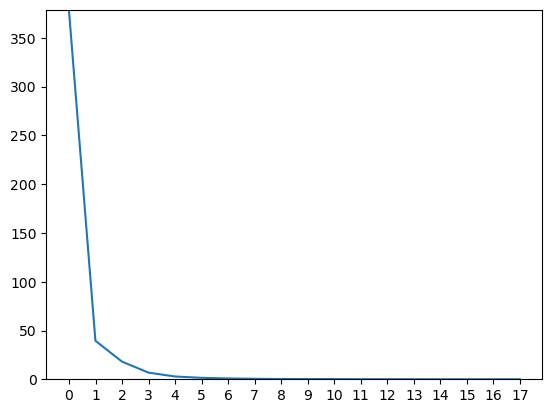

In [84]:
#Scree for elbow
import matplotlib.pyplot as plt
eigenvalues = pca2.explained_variance_ * (len(df3_pivot2) - 1)
plt.ylim(0,max(eigenvalues))
plt.xticks(np.arange(min(eigenvalues), max(eigenvalues)+1, 1.0))
plt.plot(eigenvalues)

Add 1 to each tick, elbow can be seen at 2

In [85]:
#Actual dataset that will be used
scaler = StandardScaler()
scaled_data2 = scaler.fit_transform(df3_pivot2)
pca2 = PCA(2)
pc2 = pca2.fit_transform(scaled_data2)
print("Principal components",pc2)

Principal components [[ 6.13014144  4.17654092]
 [ 5.26222471  0.99887812]
 [ 5.31678673  0.86509906]
 [ 4.69221943  0.40789037]
 [ 4.1469696  -0.04155434]
 [ 3.85174819 -0.30296353]
 [ 3.7032802  -0.40563763]
 [ 3.3068359  -0.72092977]
 [ 3.01875462 -0.98220349]
 [ 2.38575059 -1.25285378]
 [ 1.5950173  -1.52601583]
 [ 1.74196855 -2.19159515]
 [-0.3046455  -1.41031052]
 [-1.69026038 -0.88463835]
 [-1.99176663 -0.74984551]
 [-2.49688272 -0.66836798]
 [-3.09363711 -0.47426526]
 [-3.41195906 -0.11336381]
 [-3.28491389 -0.0912369 ]
 [-3.86661232  0.31412329]
 [-4.12346624  0.43959108]
 [-5.00897625  1.07531372]
 [-5.08490305  1.05503316]
 [-5.38383818  1.16004544]
 [-5.40983592  1.32326668]]


In [86]:
pca_df2 = pd.DataFrame(pc2)

In [87]:
df_final2 = pd.DataFrame()
df_final2['Year'] = df3_pivot2.reset_index()['Year'].unique()
df_final2['PC1'] = pca_df2[0]
df_final2['PC2'] = pca_df2[1]
df_final2

,Year,PC1,PC2
0,1912,6.130141,4.176541
1,1920,5.262225,0.998878
2,1924,5.316787,0.865099
3,1928,4.692219,0.407890
4,1932,4.146970,-0.041554
5,1936,3.851748,-0.302964
6,1948,3.703280,-0.405638
7,1952,3.306836,-0.720930
8,1956,3.018755,-0.982203
9,1960,2.385751,-1.252854


Variance by year makes the most sense in analyzing improvement; though PC1 shows nothing but improvement (expected, since times to improve with each Olympics), PC2 shows positive, then negative, then positive again, which may hint at a technological change towards the middle

In [88]:
vectors = pd.DataFrame(pca2.components_.T * 3)
vectors_df = pd.DataFrame()
vectors_df['Event'] = df3_pivot2.columns
vectors_df['x'] = vectors[0]
vectors_df['y'] = vectors[1]
vectors_df

,Event,x,y
0,100m Backstroke,0.745090,0.500844
1,100m Breaststroke,0.732673,-0.659983
2,100m Butterfly,0.746813,0.030773
3,100m Freestyle,0.732914,0.704103
4,1500m Freestyle,0.725142,0.666425
5,200m Backstroke,0.660084,-0.967025
6,200m Breaststroke,0.747790,0.237452
7,200m Butterfly,0.750691,-0.052373
8,200m Freestyle,0.745847,-0.518073
9,200m Medley,0.739905,-0.606527


In [89]:
df_final2.to_csv('data/olympic_swimming_pca_year.csv',index=False)
vectors_df.to_csv('data/olympic_swimming_pca_vectors.csv',index=False)

In [90]:
pca_df2

,0,1
0,6.130141,4.176541
1,5.262225,0.998878
2,5.316787,0.865099
3,4.692219,0.407890
4,4.146970,-0.041554
5,3.851748,-0.302964
6,3.703280,-0.405638
7,3.306836,-0.720930
8,3.018755,-0.982203
9,2.385751,-1.252854


MDS

In [91]:
def manhattan(x_1,y_1,x_2,y_2):
    return abs(x_1 - x_2) + abs(y_1-y_2)
pc_size = int(pc2.size/2)
dissimilarity = []
for x in range(25):
    temp = []
    x_1 = pc2[x][0]
    y_1 = pc2[x][1]
    for y in range(25):
        x_2 = pc2[y][0]
        y_2 = pc2[y][1]
        temp.append(manhattan(x_1,y_1,x_2,y_2))
    dissimilarity.append(temp)
pd_dissimilarity = pd.DataFrame(dissimilarity)
#pd_dissimilarity

In [100]:
mds = MDS(n_components=2,random_state=42,dissimilarity='precomputed')   
mds_data_coordinates = mds.fit_transform(pd_dissimilarity)
mds_data_coordinates

array([[-4.9449334 ,  8.62678921],
       [-2.27160807,  5.36007152],
       [-2.08422318,  5.43471502],
       [-1.2179113 ,  4.76523607],
       [-0.29010156,  4.27697221],
       [ 0.24905006,  4.04257008],
       [ 0.47648056,  3.91411178],
       [ 1.13495473,  3.5846539 ],
       [ 1.65915999,  3.39676874],
       [ 2.33874905,  2.79467608],
       [ 3.01115989,  1.94376932],
       [ 3.8569001 ,  2.38994776],
       [ 2.96662922, -0.38365036],
       [ 1.8817351 , -1.96044228],
       [ 1.5752176 , -2.27941794],
       [ 1.29412475, -2.82324167],
       [ 0.74891223, -3.42905147],
       [ 0.10030528, -3.75928451],
       [ 0.11324342, -3.62487965],
       [-0.7138793 , -4.24908716],
       [-0.93938753, -4.55257072],
       [-2.06965948, -5.61752831],
       [-2.11373925, -5.66479038],
       [-2.27428184, -6.04810462],
       [-2.48689704, -6.13823262]])

In [93]:
testdf = pd.DataFrame(mds_data_coordinates)
testdf

,0,1
0,-4.944933,8.626789
1,-2.271608,5.360072
2,-2.084223,5.434715
3,-1.217911,4.765236
4,-0.290102,4.276972
5,0.249050,4.042570
6,0.476481,3.914112
7,1.134955,3.584654
8,1.659160,3.396769
9,2.338749,2.794676


In [101]:
k = 2 #Per elbow
kmeans = KMeans(n_clusters=k)
cluster_ids = kmeans.fit_predict(mds_data_coordinates)
cluster_ids

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [102]:
testdf['IDs'] = cluster_ids
testdf['Year'] = np.sort(df['Year'].unique())
testdf

,0,1,IDs,Year
0,-4.944933,8.626789,1,1912
1,-2.271608,5.360072,1,1920
2,-2.084223,5.434715,1,1924
3,-1.217911,4.765236,1,1928
4,-0.290102,4.276972,1,1932
5,0.249050,4.042570,1,1936
6,0.476481,3.914112,1,1948
7,1.134955,3.584654,1,1952
8,1.659160,3.396769,1,1956
9,2.338749,2.794676,1,1960


In [103]:
testdf.to_csv('data/olympic_swimming_mds_clusters2.csv',index=False)

Additional Information

In [104]:
#every event present in a year
one_event = pd.read_csv('data/olympic_swimming_one_event.csv')
event_per_year = one_event.groupby(['Year','Gender'])['Distance'].unique()
event_df = pd.DataFrame(event_per_year).reset_index()
event_df['Distance'] = event_df['Distance'].apply(list)
event_df['Distance'] = event_df['Distance'].apply(lambda x: json.dumps(x) if isinstance(x, list) else x)
event_df.to_csv('data/unique_events_per_year.csv',index=False)

In [105]:
#7 teams with the most medals per year
medals = one_event[one_event['Rank'] != 4].groupby(['Year','Team'])['Rank'].count()
medals_df = pd.DataFrame(medals).reset_index()
medals_df = medals_df.sort_values(['Year', 'Rank'], ascending=[True, False]).groupby('Year').head(5).reset_index().drop('index',axis='columns')
medals_df.to_csv('data/top5_medal_count.csv',index=False)
